#**1) EXPLORATIVE DATA ANALYSIS**

---


In [ ]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Models and utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Pytorch library for neural network
import torch
from torch import nn, optim
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt'
]

In [ ]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

In [ ]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [ ]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [ ]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


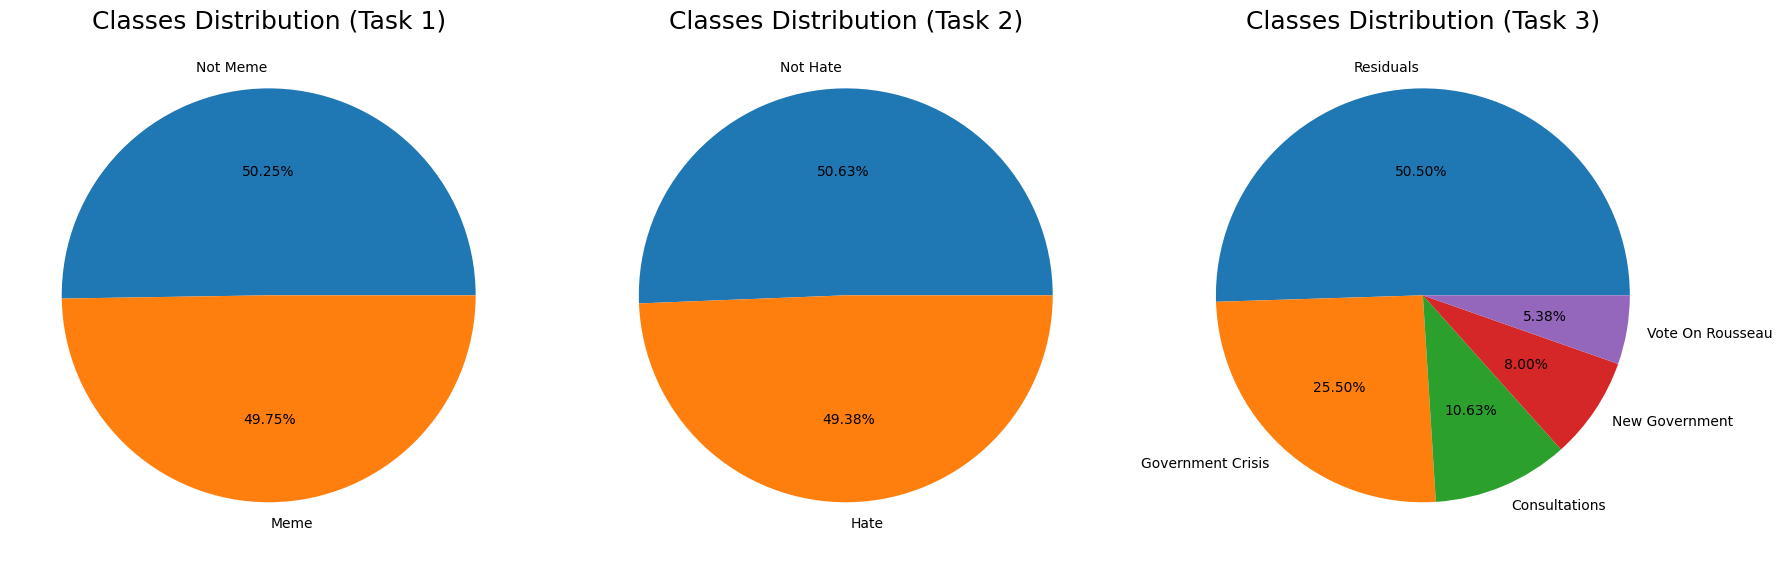

In [ ]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

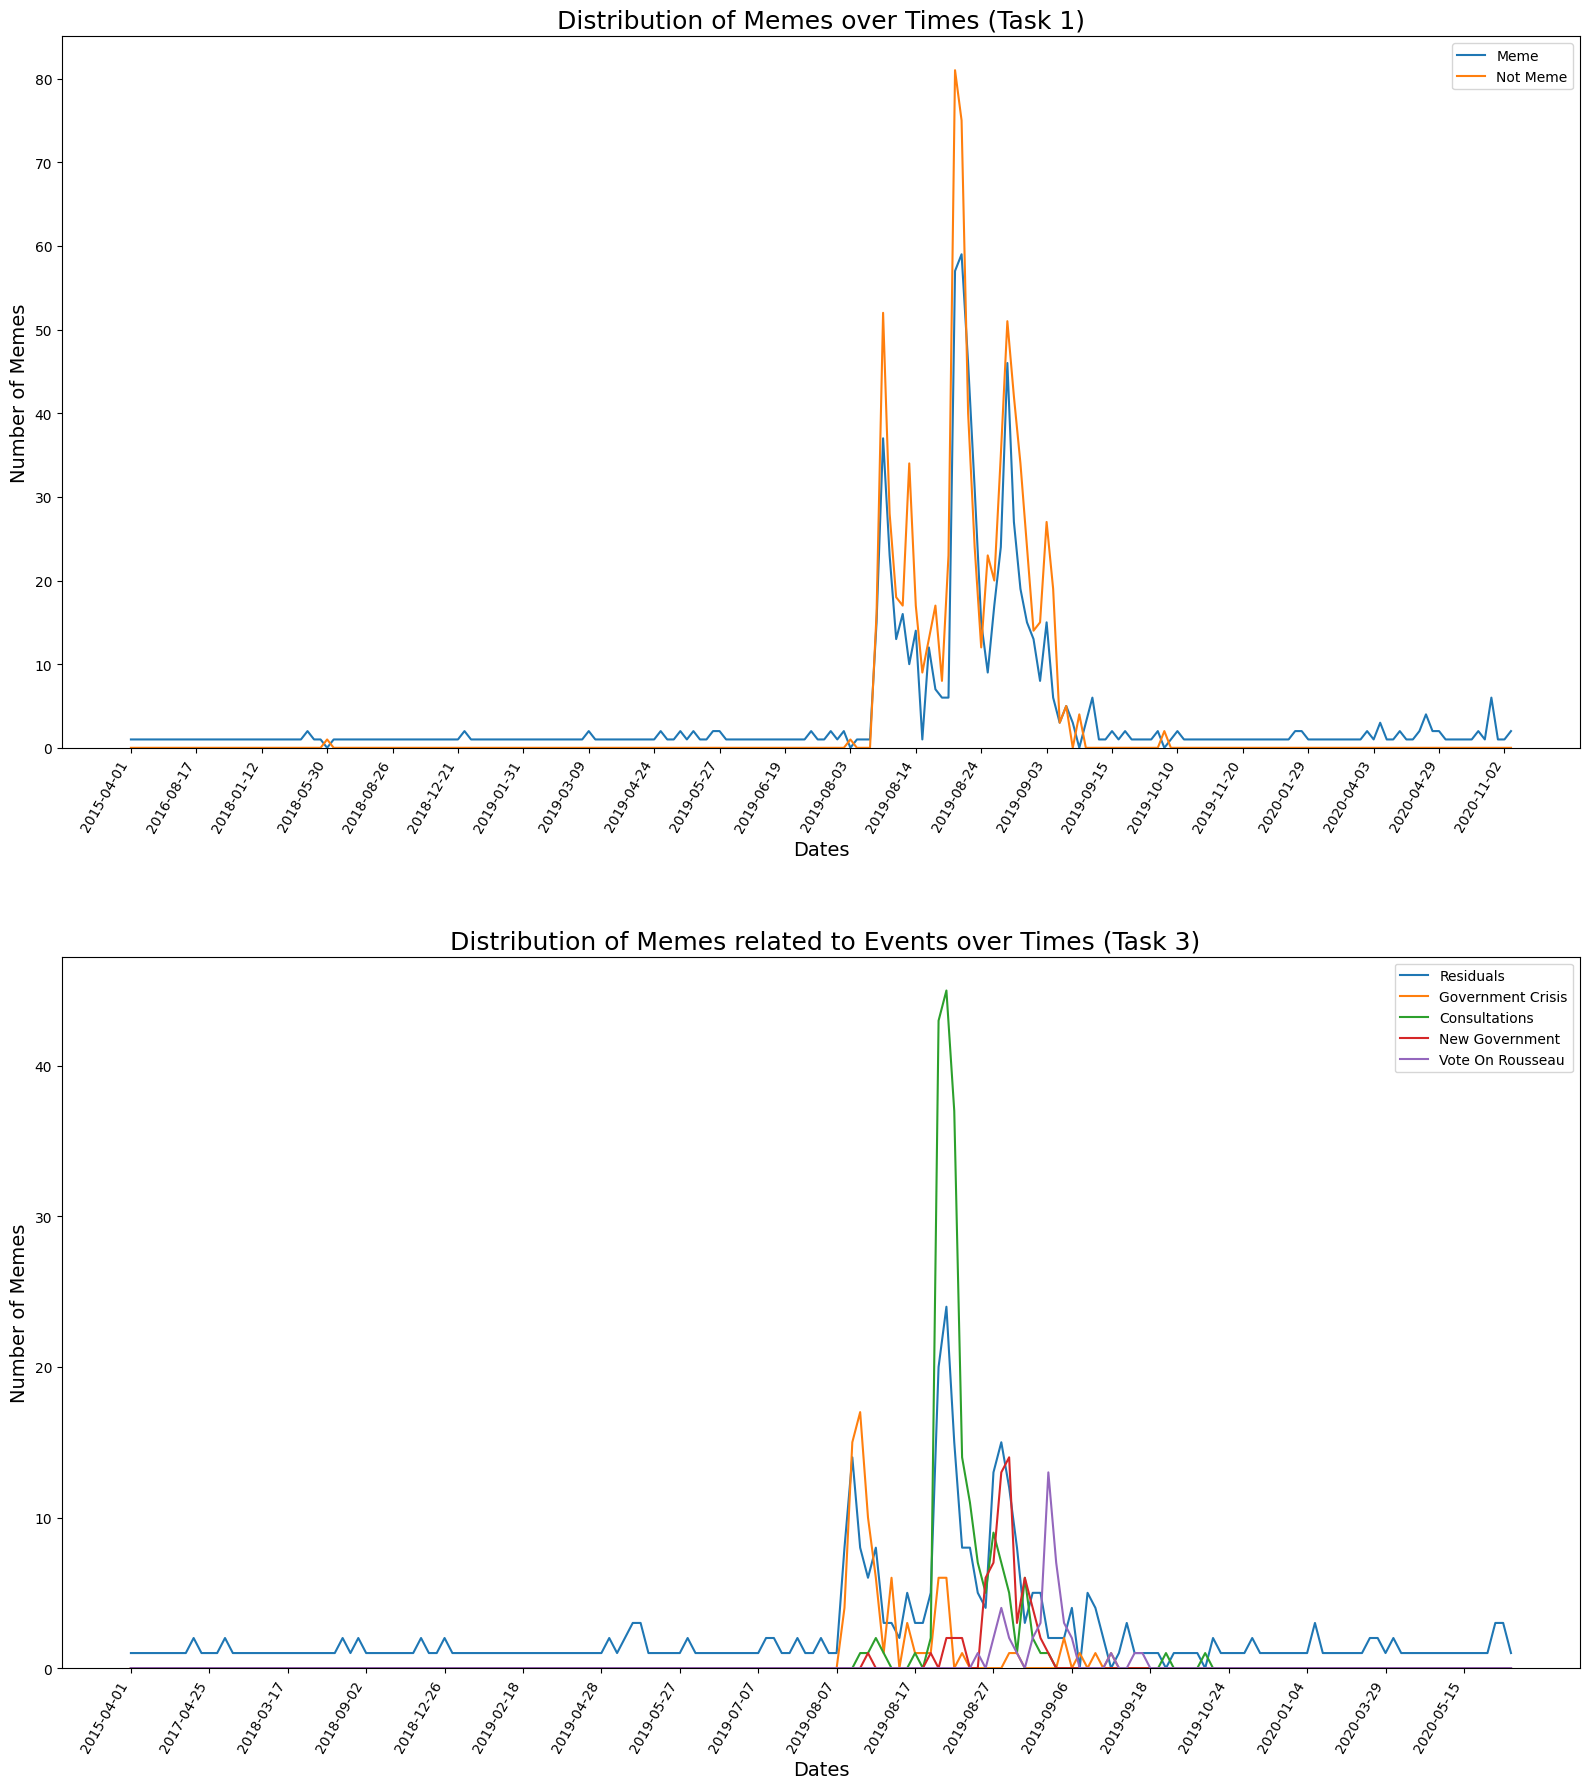

In [ ]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

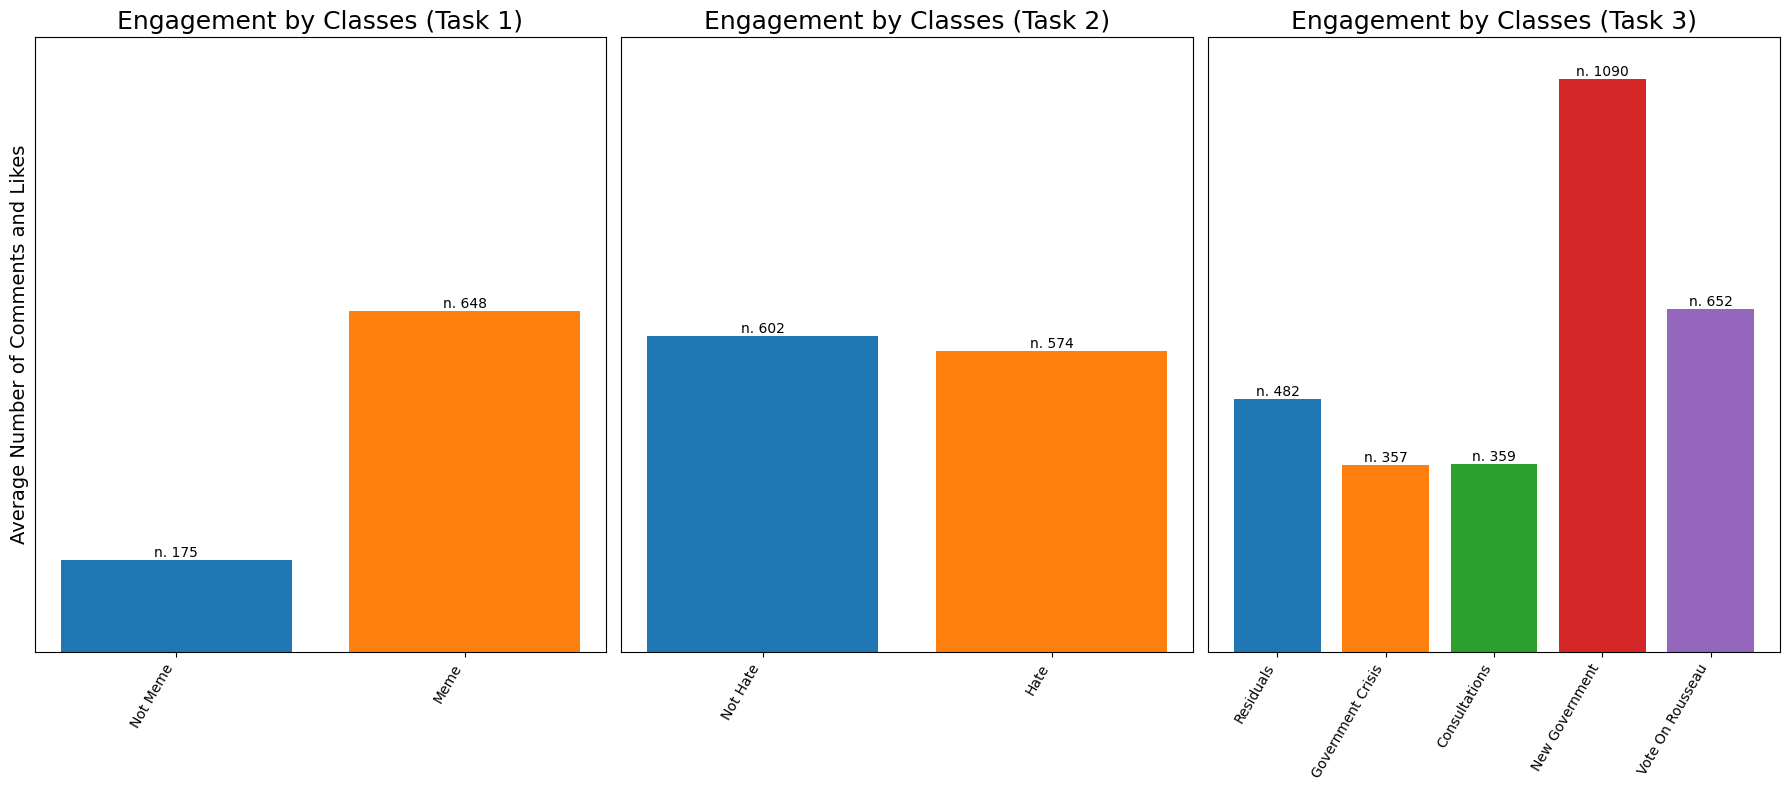

In [ ]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

#**2) PRE-PROCESSING**

---


In [ ]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [ ]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [ ]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [ ]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           60 milioni stocazzo. salvini razzista di merda brindisi non ti vuole
PROCESSED:          ['milione', 'stocazzo', 'salvini', 'razzista', 'merda', 'brindisi', 'volere']
NO_LEMMATIZATION:   ['milioni', 'stocazzo', 'salvini', 'razzista', 'merda', 'brindisi', 'vuole']


ORIGINAL:           quando conte dà le dimissioni e c'è una nuova crisi di governo oh merda, ci risiamo
PROCESSED:          ['quando', 'conte', 'dimissione', 'nuovo', 'crisi', 'governo', 'merda', 'risire']
NO_LEMMATIZATION:   ['quando', 'conte', 'dimissioni', 'nuova', 'crisi', 'governo', 'merda', 'risiamo']


ORIGINAL:           se aumenta l'iva e vuoi sapere perché #citofonarelega
PROCESSED:          ['aumentare', 'iva', 'volere', 'sapere', 'citofonarelegare']
NO_LEMMATIZATION:   ['aumenta', 'iva', 'vuoi', 'sapere', 'citofonarelega']


ORIGINAL:           il vostro nuovo presidente del consiglio sarà... sarà sarà
PROCESSED:          ['nuovo', 'presidente', 'consiglio']
NO_LEMMATIZATION:   ['nuovo', 'pres

#**3) FEATURES EXTRACTION**

---


In [ ]:
data = task_2_train

## **Text Processed**

In [ ]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
269,1269.jpg,146,0,0,hei sei sveglia? lasciami dormire ho sonno. la...,hei svegliare lasciame dormire sonno legare eu...,1
762,1762.jpg,65,1,Mattarella,quando sei mattarella e ti dicono se vuioi tor...,quando mattarella dire vuioi tornare voto akun...,0
765,1765.jpg,20,0,"Salvini, Renzi",i dei mattei. ok ragazzi vi riporto a casa!!,mattei ragazzo riportare casa,1
517,1517.jpg,409,0,Civati,"il vero fallimento non sono io, sono i vostri ...",vero fallimento meme merda normie cazzo,1
737,1737.jpg,8,0,"Mattarella, D'Uva, Di Maio","je voj ancora bene... dai, su!? si!",voj ancora bene,0
748,1748.jpg,2698,1,Mattarella,per essere un democristiano sergio sai fare ce...,essere democristiano sergio sai fare centro cazzo,1
677,1677.jpg,302,1,Berlusconi,wish you were here,wish you were here,1
260,1260.jpg,66,0,0,non è il momento delle polemiche siamo in una ...,momento polemico emergenza salvini sfiducio cr...,1
281,1281.jpg,6,1,Mattarella,il presidente mattarella accoglie la delegazio...,presidente mattarella accogliere delegazione l...,0
173,1173.jpg,2343,0,"Conte, Casalino",ogni nazione ha la first lady che si merita !!!,ogni nazione first lady meritare,1


## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [ ]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Lega,-9,7,-2
Santanchè,-1,0,-1
Civati,-1,1,0
Meloni,-8,10,2
Rosy Bindi,-1,0,-1
Delrio,-1,0,-1
Gelmini,-2,1,-1
Toninelli,-2,0,-2
Di Maio,-42,71,29
Fico,-2,2,0


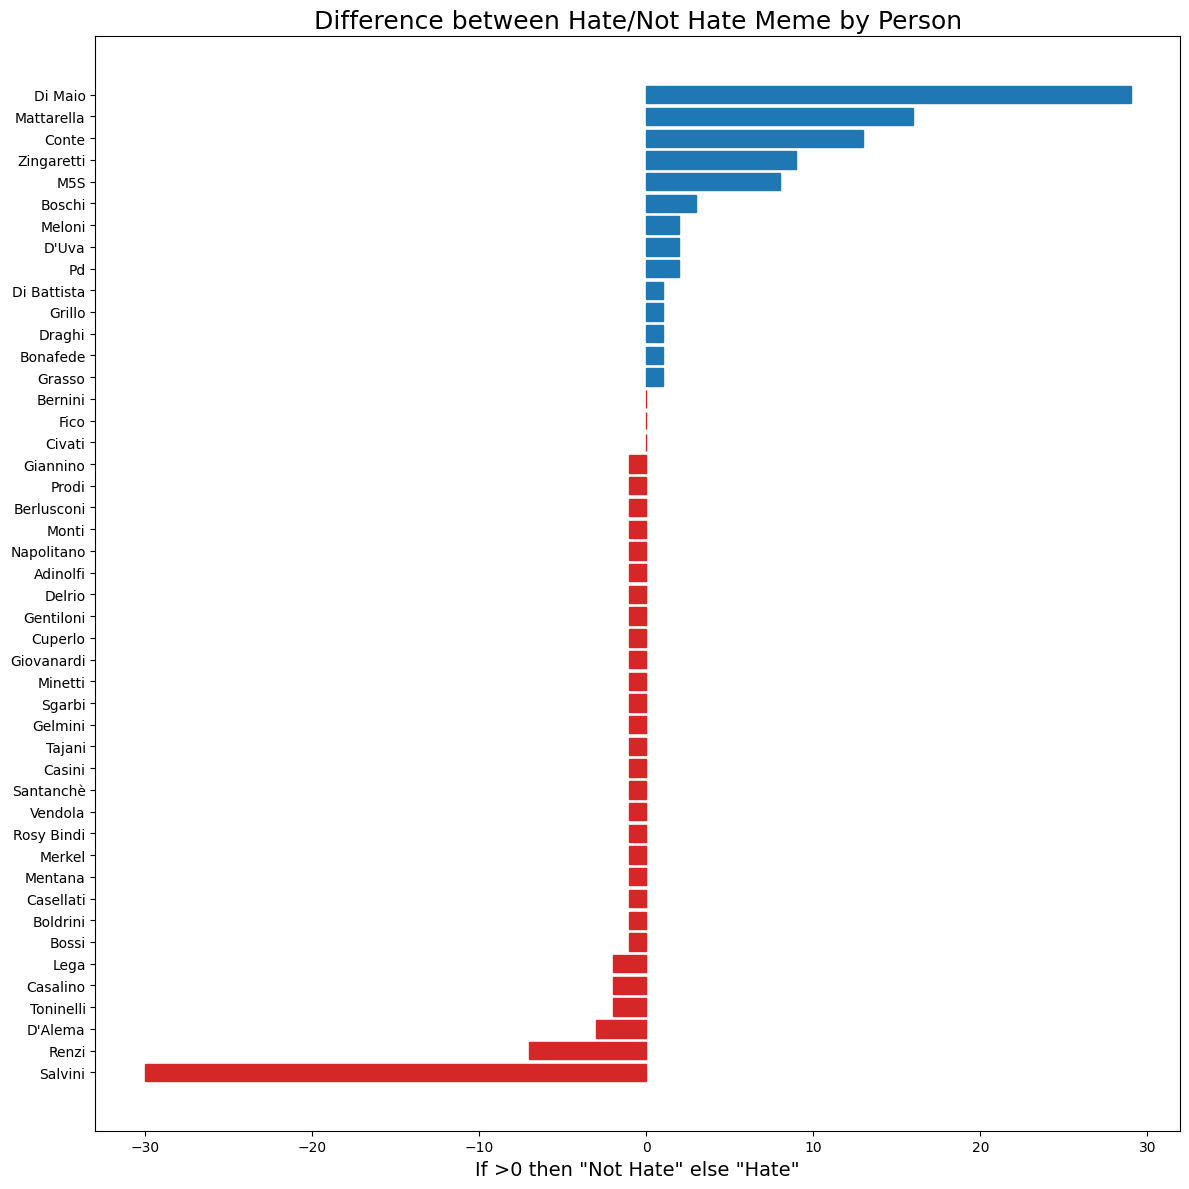

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [ ]:
# The hate score is given by the difference between the number of 
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
732,1732.jpg,65,0,Di Maio,29.0,si addormenta sul materassino con la lega e lo...,addormentare materassino legare ritrovare ora ...,0
29,1029.jpg,0,0,0,NaN,santanché soddisfatta che la sfiducia a conte ...,santanché soddisfatto sfiducia conte agenda ag...,0
455,1455.jpg,581,0,Salvini,-30.0,quando sali tutto convinto sulla tua ruspa per...,quando sale convinto ruspa asfaltare campo rom...,0
539,1539.jpg,135,0,Salvini,-30.0,domani ricominciano le consultazioni e io non ...,domani ricominciare consultazione ancora rosar...,0
422,1422.jpg,76,0,"Salvini, Conte",-17.0,e tien pur e' corn,tien pure corn,1
579,1579.jpg,353,1,"Salvini, Di Maio",-1.0,matthew salvini tinyluis dimayo il nome della ...,matthew salvini tinyluis dimayo nome legare cr...,0
627,1627.jpg,206,0,"Salvini, Di Maio",-1.0,certi amori non finiscono fanno consultazioni ...,certo amore finire consultazione immenso poi r...,0
388,1388.jpg,806,0,"Berlusconi, Salvini",-31.0,guarda co di maio ce so annato solo per capi q...,guardare maio annare solo capo tenevi,0
42,1042.jpg,9,0,0,NaN,mi scusi signora questo posto è riservato ai d...,scusi signore posto riservato disabile comunis...,1
131,1131.jpg,784,1,Mattarella,16.0,italy parental advisory eman rus,italy parental advisory eman rus,0


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [ ]:
data['Nr Words Text'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Hate Speech
502,1502.jpg,2,0,Salvini,-30.0,"""peggio che me tocca de lava' tutte e divise!!""",peggio toccare lavare tutto divisa,9,0
16,1016.jpg,641,1,"Salvini, Di Maio",-1.0,alexa spegni il governo,spegno governo,4,0
790,1790.jpg,185,0,0,NaN,"e così abbiamo pensato, facciamo un bel proget...",così pensare bello progetto crisi governare gr...,37,1
462,1462.jpg,360,1,Mattarella,16.0,architrash vs fight!,architrash fight,3,0
552,1552.jpg,3,0,Salvini,-30.0,perché nessuno lo fa fuori???,nessuno fuori,5,1
260,1260.jpg,66,0,0,NaN,non è il momento delle polemiche siamo in una ...,momento polemico emergenza salvini sfiducio cr...,21,1
718,1718.jpg,3,1,Conte,13.0,conte 2 la vendetta,conte vendettare,4,0
786,1786.jpg,11,0,0,NaN,discovering something that doesn't exist gover...,discovering something that governo italiano,7,0
454,1454.jpg,24,1,Conte,13.0,il governo è servito,governo servire,4,1
761,1761.jpg,11,1,0,NaN,di maio contro salvini di maio contro zingaretti,maio salvini maio zingaretti,8,0


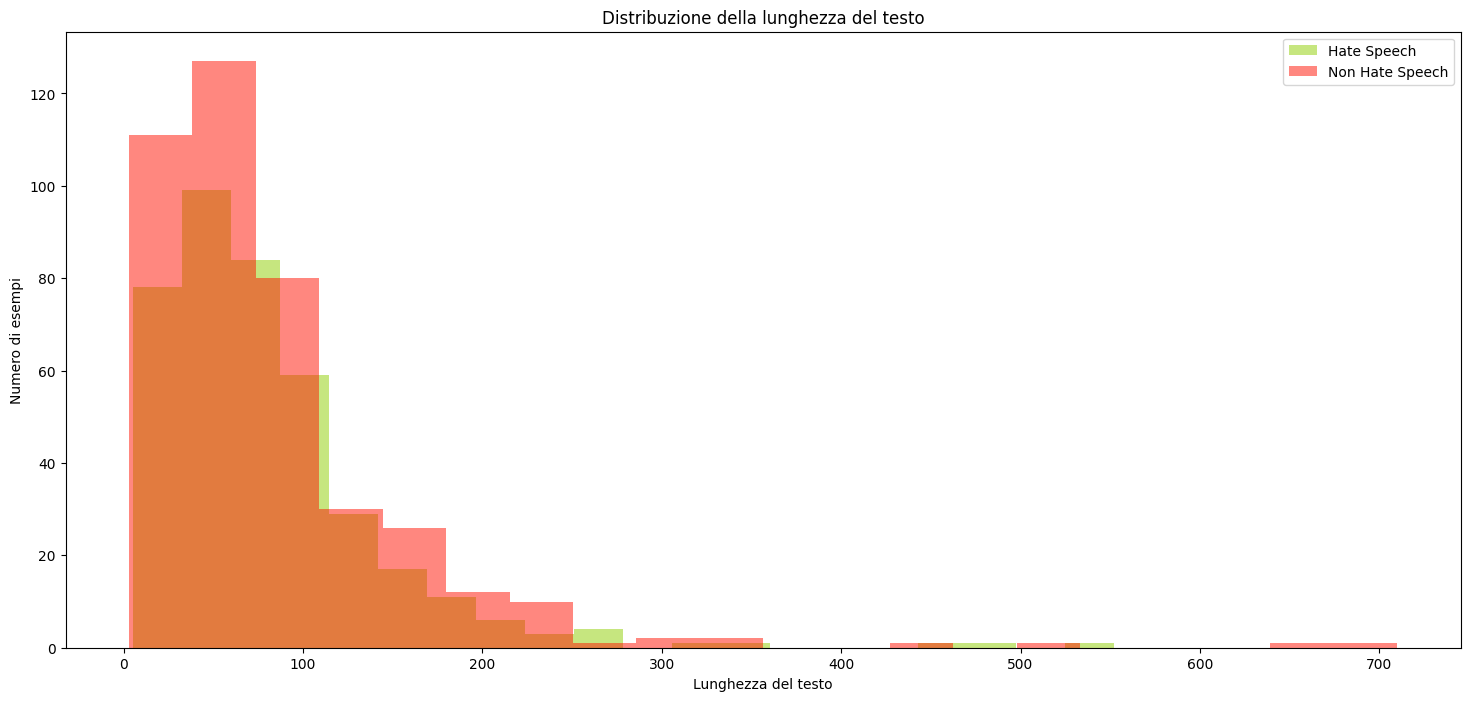

In [ ]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Nr Words Text'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words Text'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

## **NER**

In [ ]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
62,1126.jpg,salvini,PER
345,1725.jpg,giuse,PER
314,1637.jpg,"salvino, m5s","PER, ORG"
207,1442.jpg,"parma, juve, napoli, milano, brescia","LOC, ORG, ORG, LOC, LOC"
165,1343.jpg,waiting for,MISC
18,1032.jpg,contagio lombardia,LOC
222,1468.jpg,italia,LOC
307,1622.jpg,giuseppo here giuseppo,PER
29,1061.jpg,"salvini, matteo salvini","PER, PER"
204,1437.jpg,"activia accendre renzi rai cagare, piuo","PER, MISC"


## **Words Embedding**

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [ ]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Doc2Vec', 'Nr Words Text', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[-0.00081033685, 0.00063253863, 0.0005470255, ...",15,1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[0.0008660573, -0.0010320138, 0.0005954543, -0...",14,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.00092039467, -0.0009244649, -0.00027581118...",17,1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[0.00018996834, 0.00035786658, -0.0005255088, ...",9,1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[-3.8286074e-05, -0.0005146302, 0.0012303687, ...",26,0


#**4) MODELS DEFINITION**

---


## **Support Vector Classifier**

## **Recurrent Neural Network (????)**

## **Long-Short Term Memory**

## **Transformer (????)**